

## Predict Product Prices

### And now, to evaluate our fine-tuned open source model



In [ ]:
# pip installs

!pip install -q datasets peft requests torch bitsandbytes transformers trl accelerate sentencepiece matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [ ]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
#PROJECT_NAME = "pricer"
#HF_USER = "ed-donner" # your HF name here! Or use mine if you just want to reproduce my results.

PROJECT_NAME = 'lite-data3'
HF_USER = "timbosssds" # your HF name here!
DATASET_NAME = "timbosssds/lite-data3"


# The run itself

# RUN_NAME = "2024-09-13_13.04.39"
# PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
# REVISION = "e8d637df551603dc86cd7a1598a8f44af4d7ae36" # or REVISION = None
# FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

REVISION = None
#FINETUNED_MODEL = 'timbosssds/lite-data2-2025-01-29_02.05.55'
FINETUNED_MODEL = 'timbosssds/lite-data3-2025-01-30_00.47.44'

# Uncomment this line if you wish to use my model
# FINETUNED_MODEL = f"ed-donner/{PROJECT_RUN_NAME}"

# Data

#DATASET_NAME = f"{HF_USER}/pricer-data"
# Or just use the one I've uploaded
# DATASET_NAME = "ed-donner/pricer-data"

# Hyperparameters for QLoRA

QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Log in to HuggingFace

If you don't already have a HuggingFace account, visit https://huggingface.co to sign up and create a token.

Then select the Secrets for this Notebook by clicking on the key icon in the left, and add a new secret called `HF_TOKEN` with the value as your token.


In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/405 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/199k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/776k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\n𝐎𝐄𝐌 Water Inlet Valve for SAMSUNG Washer - 5 Years Warranty-Replaces Models\n✅ 𝐖𝐀𝐓𝐄𝐑 𝐈𝐍𝐋𝐄𝐓 𝐕𝐀𝐋𝐕𝐄 𝐒𝐀𝐌𝐒𝐔𝐍𝐆 GENUINE Washer Water Inlet Valve 𝐒𝐀𝐌𝐒𝐔𝐍𝐆 with Mounting Bracket,High quality,good price, fast Amazon official logistics.This is a new GENUINE Samsung replacement part.( V, 60 Washing Machine Water Inlet Valve\n\nPrice is $',
 'price': 32.77}

## Now load the Tokenizer and Model

In [ ]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [ ]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

FINETUNED_MODEL = FINETUNED_MODEL

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


# THE MOMENT OF TRUTH!

## Use the model in inference mode

Remember, GPT-4o had an average error of \$76.  
Llama 3.1 base model had an average error of \$396.   
This human had an error of \$127.  

## Caveat

Keep in mind that prices of goods vary considerably; the model can't predict things like sale prices that it doesn't have any information about.

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [ ]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [ ]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [ ]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $31.70 Truth: $32.77 Error: $1.07 SLE: 0.00 Item: 𝐎𝐄𝐌 Water Inlet Valv...
2: Guess: $505.25 Truth: $399.99 Error: $105.26 SLE: 0.05 Item: ROVSUN Commercial Ic...
3: Guess: $12.22 Truth: $22.37 Error: $10.15 SLE: 0.32 Item: Washer Lid Lock Latc...
4: Guess: $9.12 Truth: $14.99 Error: $5.87 SLE: 0.21 Item: Washing Machine Wash...
5: Guess: $20.86 Truth: $17.49 Error: $3.37 SLE: 0.03 Item: MSDADA Stove Top Cov...
6: Guess: $20.91 Truth: $11.99 Error: $8.92 SLE: 0.27 Item: EFIELD 10 FT Stainle...
7: Guess: $18.39 Truth: $49.95 Error: $31.56 SLE: 0.93 Item: Dishwasher Silverwar...
8: Guess: $11.04 Truth: $11.99 Error: $0.95 SLE: 0.01 Item: American Metal Filte...
9: Guess: $9.99 Truth: $5.77 Error: $4.22 SLE: 0.23 Item: Sikawai Unbreakable ...
10: Guess: $10.34 Truth: $13.99 Error: $3.65 SLE: 0.08 Item: 250 Clear Shrink Wra...
11: Guess: $10.31 Truth: $14.99 Error: $4.68 SLE: 0.12 Item: 2-Pack Dryer Lint Fi...
12: Guess: $9.99 Truth: $9.99 Error: $0.00 SLE: 0.00 Item: HASMX Y54414

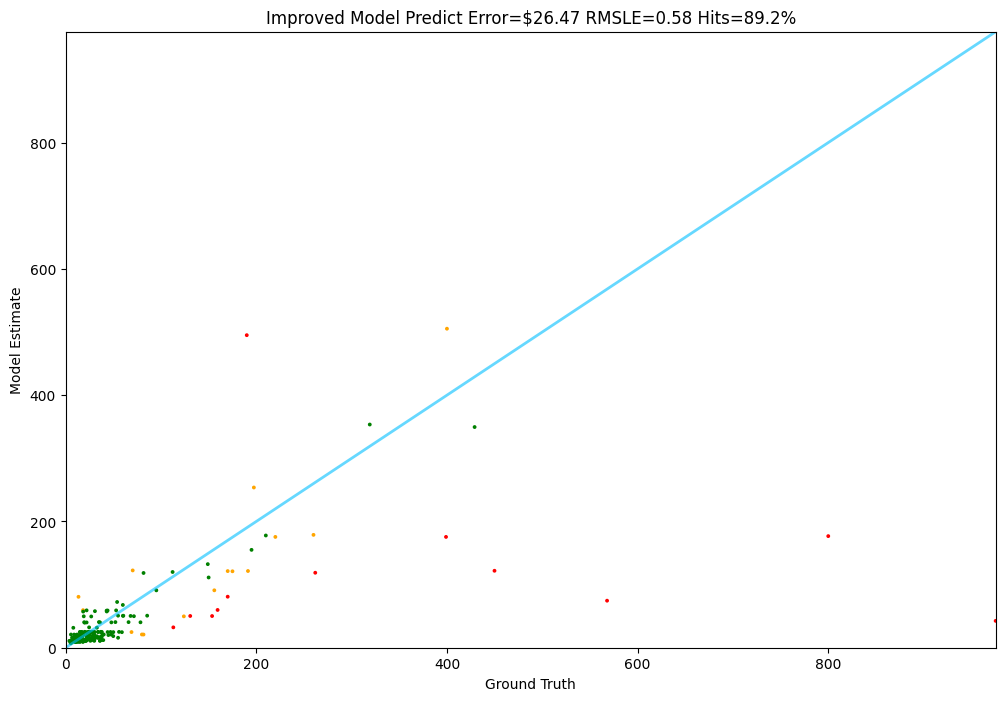

In [ ]:
Tester.test(improved_model_predict, test)